In [1]:
import glob
import os
from collections import Counter
import string
from keras import Input
from keras.layers import Dense, Lambda, Conv1D
import keras.backend as K
from keras.models import Model
from keras.objectives import binary_crossentropy, mse
import os
import random
import numpy as np
import pickle
import random
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from keras.optimizers import RMSprop, Adam
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import load_model
from tempfile import TemporaryFile

Using TensorFlow backend.


In [2]:
families = ["fam_1", "fam_2", "fam_3", "fam_4", "fam_5", "fam_6", "fam_7", "fam_8", "fam_9"]
ds_path = "test_data"

family_paths = {}
for f in families:
    family_paths[f]= os.path.join(ds_path, f)

In [3]:
letters_di=dict(zip(string.ascii_letters,[ord(c)%32 -1 for c in string.ascii_letters]))

In [4]:
padding = True
num_classes = 25
categorical = True
normalize = False
max_length = 668
flatten = True

In [5]:
def process_conf(configurations, categorical, padding, max_length, normalize, flatten):
    configurations = [[letters_di[l] for l in p] for p in configurations]
    if categorical:
        # tranforms data to one hot encodings
        configurations = [to_categorical(p, num_classes=num_classes) for p in configurations]  
    configurations = np.array(configurations)
    if padding:
        # pad sequences if less than max length
        new_families_conf = np.zeros((configurations.shape[0], max_length, num_classes))
        for i,f in enumerate(configurations):
            new_families_conf[i,:f.shape[0], :f.shape[1]] += f
        configurations = new_families_conf
        del new_families_conf
    if flatten:
        configurations = configurations.reshape(-1, num_classes * max_length)
    if normalize:
        configurations = configurations.astype('float32') / (letters_di['Y'] * 1.0)
    return configurations

In [6]:
def load_family(f):
    proteins = glob.glob(os.path.join(family_paths[f], "*.txt"))
    print("Proteins for family %s" %f)
    for p in proteins:
        print(p)
    proteins_conf = []
    for p in proteins:
        with open(p) as in_file:
            for line in in_file:
                proteins_conf.append(line.strip())
    l = [len(p) for p in proteins_conf]
    print(Counter(l))
    proteins_conf = process_conf(proteins_conf, categorical=categorical, padding=padding, max_length=max_length,normalize=normalize, flatten=flatten)
    return proteins_conf

In [7]:
families_conf = {}
for f in families:
    families_conf[f] = load_family(f)

Proteins for family fam_1
test_data/fam_1/1ITX.txt
test_data/fam_1/1JFX.txt
test_data/fam_1/1KFW.txt
test_data/fam_1/1EDG.txt
test_data/fam_1/1VFF.txt
test_data/fam_1/1NAR.txt
test_data/fam_1/2EBN.txt
test_data/fam_1/1CNV.txt
test_data/fam_1/1B1Y.txt
Counter({416: 2500, 214: 2500, 432: 2500, 377: 2500, 420: 2500, 286: 2500, 282: 2500, 280: 2500, 497: 2500})
Proteins for family fam_2
test_data/fam_2/1ITH.txt
test_data/fam_2/1MBA.txt
test_data/fam_2/1DLW.txt
test_data/fam_2/1HLB.txt
test_data/fam_2/1ASH.txt
test_data/fam_2/2LHB.txt
test_data/fam_2/1ECA.txt
test_data/fam_2/2HBG.txt
Counter({144: 5000, 279: 2500, 143: 2500, 113: 2500, 154: 2500, 146: 2500, 133: 2500})
Proteins for family fam_3
test_data/fam_3/2SAS.txt
test_data/fam_3/1IQ3.txt
test_data/fam_3/1UHN.txt
test_data/fam_3/1CB1.txt
test_data/fam_3/1SRA.txt
test_data/fam_3/1OMR.txt
Counter({182: 2500, 107: 2500, 186: 2500, 75: 2500, 148: 2500, 198: 2500})
Proteins for family fam_4
test_data/fam_4/1JT8.txt
test_data/fam_4/1SLJ.txt


In [8]:
for f in families:
    families_conf[f] = random.sample(list(families_conf[f]), 50)

In [9]:
models = {"fam_1": "models_proteins_exp1/fam_1/model_protein_level_fam_1.hdf5",
          "fam_2": "models_proteins_exp1/fam_2/model_protein_level_fam_2.hdf5",
          "fam_3": "models_proteins_exp1/fam_3/model_protein_level_fam_3.hdf5",
          "fam_4": "models_proteins_exp1/fam_4/model_protein_level_fam_4.hdf5",
          "fam_5": "models_proteins_exp1/fam_5/model_protein_level_fam_5.hdf5",
          "fam_6": "models_proteins_exp1/fam_6/model_protein_level_fam_6.hdf5",
          "fam_7": "models_proteins_exp1/fam_7/model_protein_level_fam_7.hdf5",
          "fam_8": "models_proteins_exp1/fam_8/model_protein_level_fam_8.hdf5",
          "fam_9": "models_proteins_exp1/fam_9/model_protein_level_fam_9.hdf5"}

In [10]:
model = load_model(models["fam_1"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16700)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                334020    
_________________________________________________________________
dense_2 (Dense)              (None, 16700)             350700    
Total params: 684,720
Trainable params: 684,720
Non-trainable params: 0
_________________________________________________________________


In [12]:
model_input = model.input
model_hidden = model.layers[1].output

In [13]:
encoder = K.function([model_input], [model_hidden])

In [24]:
encoded = {}
for f in families:
    encoded[f] = [encoder([np.expand_dims(c, axis=0)])[0] for c in families_conf[f]]
    encoded[f] = [e[0] for e in encoded[f]]

In [26]:
len(encoded["fam_1"])

50

In [28]:
all_encodings = []
for f in families:
    all_encodings += encoded[f]

model = TSNE(n_components = 2)
np.set_printoptions(suppress = True)
encoded2d = model.fit_transform(all_encodings)

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# both df1 and df2 have bivaraite normals, df1.size=200, df2.size=100
nr = 50

df1 = pd.DataFrame(encoded2d[:50], columns=['x', 'y'])
df2 = pd.DataFrame(encoded2d[50:100], columns=['x', 'y'])
df3 = pd.DataFrame(encoded2d[100:150], columns=['x', 'y'])
df4 = pd.DataFrame(encoded2d[150:200], columns=['x', 'y'])
df5 = pd.DataFrame(encoded2d[200:250], columns=['x', 'y'])
df6 = pd.DataFrame(encoded2d[250:300], columns=['x', 'y'])
df7 = pd.DataFrame(encoded2d[300:350], columns=['x', 'y'])
df8 = pd.DataFrame(encoded2d[350:400], columns=['x', 'y'])
df9 = pd.DataFrame(encoded2d[400:], columns=['x', 'y'])


In [32]:
concatenated = pd.concat([df1.assign(dataset='fam_1'), 
                          df2.assign(dataset='fam_2'),
                          df3.assign(dataset='fam_3'),
                          df4.assign(dataset='fam_4'),
                          df5.assign(dataset='fam_5'),
                          df6.assign(dataset='fam_6'),
                          df7.assign(dataset='fam_7'),
                          df8.assign(dataset='fam_8'),
                          df9.assign(dataset='fam_9')])

In [33]:
concatenated

,x,y,dataset
0,-13.053392,-30.654980,fam_1
1,-18.084236,-13.595737,fam_1
2,-20.149668,-9.043389,fam_1
3,-13.354793,-15.874166,fam_1
4,-14.988413,-29.930002,fam_1
5,-12.599085,-31.619961,fam_1
6,-12.288172,-31.352352,fam_1
7,-10.320660,-27.244059,fam_1
8,-13.408784,-30.708233,fam_1
9,-13.301487,-31.826185,fam_1


In [40]:
%matplotlib inline
plt.figure(figsize=(16, 16))

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

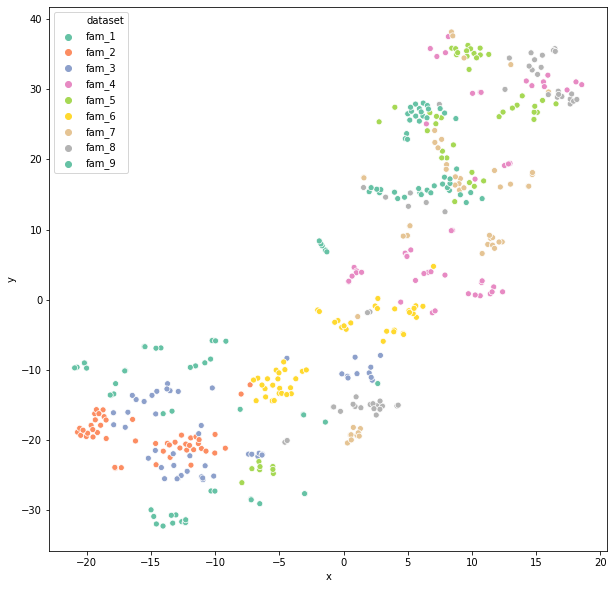

In [43]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="x", y="y", hue="dataset",data=concatenated, palette="Set2")